# Posterior plots

See the other version of this notebook (`nice_corners--z0.51_0.61.ipynb`) for more detailed comments.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import getdist
from getdist import plots, MCSamples
from matplotlib.colors import TABLEAU_COLORS
import glob
import matplotlib.patches as mpatches
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde

In [2]:
path_to_repo = "/Users/jamie/Desktop/GitHubProjects/matryoshka_II_paper/"

In [3]:
def make_corner(samples_list, inflated=None, savev=None):
    g = plots.get_subplot_plotter(width_inch=9)

    g.settings.axes_fontsize = 12.5
    #g.settings.num_plot_contours = 1
    if inflated is None:
        g.triangle_plot(samples_list, filled=False, contour_colors=list(TABLEAU_COLORS.keys()), contour_lws=1.5)
    else:
        g.triangle_plot([inflated]+samples_list,
                        filled=[True]+len(samples_list)*[False],
                        contour_colors=['lightgrey']+list(TABLEAU_COLORS.keys()), contour_lws=1.5)

    # Note: This loop of axes is not really needed.
    # GetDist has functionality for adding truths.
    for i in range(truths.shape[0]):
        for j in range(truths.shape[0]):
            if i == j:
                g.subplots[i,j].axvline(truths[i], color='gray', ls='--')
            elif j < i:
                g.subplots[i,j].axvline(truths[j], color='gray', ls='--')
                g.subplots[i,j].axhline(truths[i], color='gray', ls='--')
                
    if savev is not None:
        g.export(path_to_repo+f"plots/corner_pybird--z-0.38--Vi-{savev}--all.pdf")

In [4]:
def make_IS(weights, chain, limit=None):
    if limit is not None:
        samples = MCSamples(samples=chain[:limit],
                                   names=names, labels=labels, weights=weights[:limit], label="PyBird IS",
                                   ranges=bounds_dict)
        samples.updateSettings({'smooth_scale_2D': 0.4, 'smooth_scale_1D':0.2})
    else:
        samples = MCSamples(samples=chain,
                           names=names, labels=labels, weights=weights, label="PyBird IS",
                           ranges=bounds_dict)
        samples.updateSettings({'smooth_scale_2D': 0.4, 'smooth_scale_1D':0.2})
    return samples

In [5]:
labels = [r"\omega_c",r"h",r"A_s", r"b_1", r"c_2", r"b_3", r"c_{ct}", r"c_{r,1}",
          r"c_{\epsilon,1}", r"c_{\epsilon,quad}"]
names = ["omega_c","h","As", "b1", "c2", "b3", "cct", "cr1", "ce1", "cq"]

bounds_dict = {"omega_c": [0.109988, 0.129229], 
               "h": [0.57451438, 0.74766042], 
               "As": [2.77885117, 3.32142323], 
               "b1": [0., 4.], 
               "c2": [-4., 4.]}

In [6]:
cosmo_true = np.array([0.11933, 0.02242, 0.6766, 3.047, 0.9665])
bs_LOWZ = np.array([1.73, 1.0, -1.0, 0.0, 0.2, -10.03, 0., 0., 0., -2.1])
truths = np.concatenate([cosmo_true[[0,2,3]], bs_LOWZ[[0,1,2,4,5,7,9]]])

In [7]:
Vlist = [1000, 2000, 3000, 4000, 5000]
samples_list = []
IS_list = []
for Vi in Vlist:
    samples_list.append(MCSamples(samples=np.load(glob.glob(path_to_repo+f"results/chain*z-0.38*V-{Vi}*.npy")[0]),
                                  names=names, labels=labels, label=f"EFTEMU $V_s = {str(Vi)}^3$", 
                                  ranges=bounds_dict))
    samples_list[-1].updateSettings({'smooth_scale_2D': 0.4, 'smooth_scale_1D':0.2})
    
    if Vi>2000 and Vi<5000:
        Vc = Vi-1000
    elif Vi==5000:
        continue
    else:
        Vc = Vi
    
    weights_file = glob.glob(path_to_repo+f"results/weights*0.38*{Vc}*{Vi}*all.npy")[0]
    weights = np.load(weights_file)
    weights = weights/weights.sum()

    chain = np.load(glob.glob(path_to_repo+f"results/chain*z-0.38*V-{Vc}*--shuffled.npy")[0])[-weights.shape[0]:]
    IS_list.append(make_IS(weights, chain))

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


In [8]:
Vi = 5000
Vc = 3000

chain_file = glob.glob(path_to_repo+f"results/chain--EFTEMU_z-0.38_V-{Vc}*--shuffled.npy")[0]
emu_chain = np.load(chain_file)

weights_file = glob.glob(path_to_repo+f"results/weights*0.38*{Vc}*{Vi}*all.npy")[0]
weights = np.load(weights_file)
weights = weights/weights.sum()

IS_list.append(make_IS(weights, emu_chain[-weights.shape[0]:]))

Removed no burn in


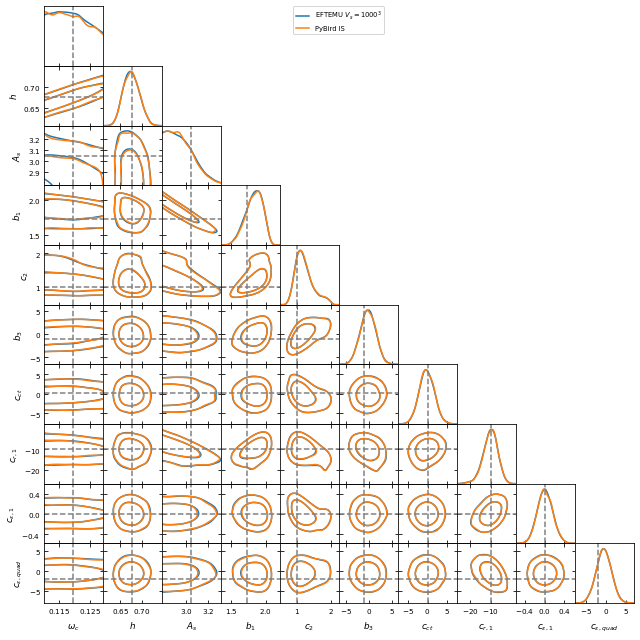

In [9]:
make_corner([samples_list[0], IS_list[0]], savev=1000)

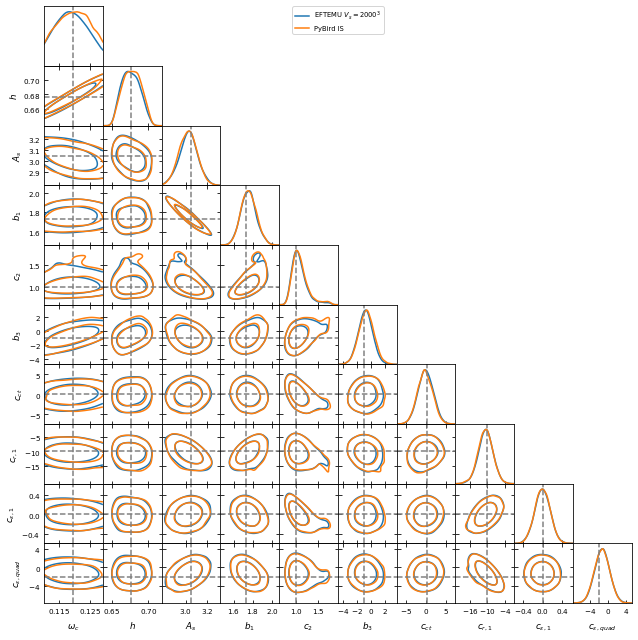

In [10]:
make_corner([samples_list[1], IS_list[1]], savev=2000)

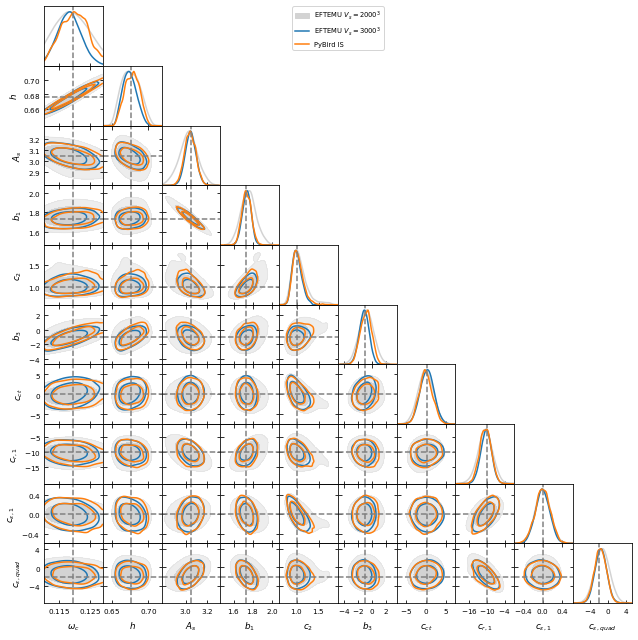

In [11]:
make_corner([samples_list[2], IS_list[2]], inflated=samples_list[1], savev=3000)

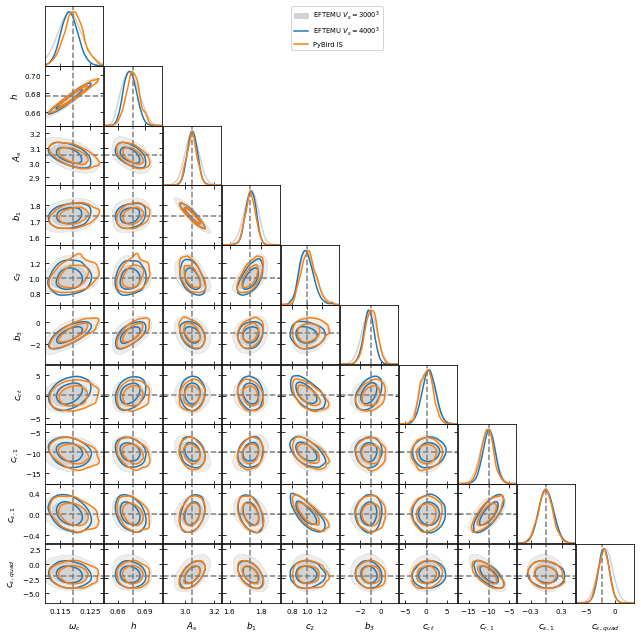

In [12]:
make_corner([samples_list[3], IS_list[3]], inflated=samples_list[2], savev=4000)

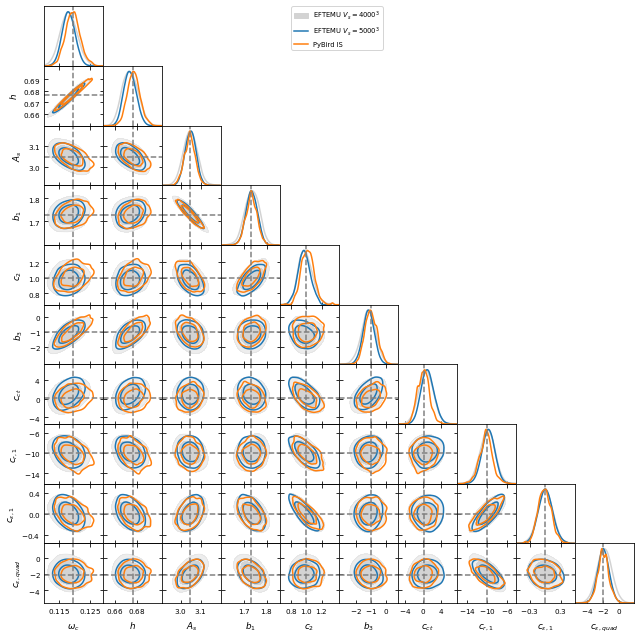

In [13]:
make_corner([samples_list[4], IS_list[4]], inflated=samples_list[3], savev=5000)

In [14]:
marg_stats_pybird_allV = []
marg_stats_emu_allV = []

for j, Vj in enumerate([1000,2000,3000,4000,5000]):
    print("++++++++++++++++")
    print(f"V={Vj}^3")
    marg_stats_pybird_Vi = []
    marg_stats_emu_Vi = []
    for param_i in ['omega_c', 'h', 'As', 'b1']:
        xs = np.linspace(bounds_dict[param_i][0], bounds_dict[param_i][1],1000)

        pybird_kde = IS_list[j].get1DDensity(param_i)
        emu_kde = samples_list[j].get1DDensity(param_i)

        pybird_pdf = pybird_kde.Prob(xs)
        pybird_cdf = np.cumsum(pybird_pdf)
        pybird_cdf /= pybird_cdf.max()
        pybird_cdf_int = interp1d(pybird_cdf, xs)
        pybird_marg_stats = pybird_cdf_int([0.16,0.5,1-0.16])

        emu_pdf = emu_kde.Prob(xs)
        emu_cdf = np.cumsum(emu_pdf)
        emu_cdf /= emu_cdf.max()
        emu_cdf_int = interp1d(emu_cdf, xs)
        emu_marg_stats = emu_cdf_int([0.16,0.5,1-0.16])

        print(f"Mean_shift {param_i}: ",(emu_marg_stats[1]-pybird_marg_stats[1])/((pybird_marg_stats[-1]-pybird_marg_stats[0])*0.5))
        print(f"Width ratio {param_i}: ", (emu_marg_stats[-1]-emu_marg_stats[0])/(pybird_marg_stats[-1]-pybird_marg_stats[0]))
        
        marg_stats_pybird_Vi.append(pybird_marg_stats)
        marg_stats_emu_Vi.append(emu_marg_stats)
        
    marg_stats_pybird_allV.append(np.stack(marg_stats_pybird_Vi))
    marg_stats_emu_allV.append(np.stack(marg_stats_emu_Vi))   
    

++++++++++++++++
V=1000^3
Mean_shift omega_c:  0.016956099458479756
Width ratio omega_c:  0.9881325359062328
Mean_shift h:  -0.02076794752271808
Width ratio h:  0.9974409771529931
Mean_shift As:  0.03143892262369892
Width ratio As:  1.0293969192071248
Mean_shift b1:  -0.02441314861844665
Width ratio b1:  1.0181462749097474
++++++++++++++++
V=2000^3
Mean_shift omega_c:  -0.13734391646099461
Width ratio omega_c:  0.953497394923591
Mean_shift h:  -0.13961470764582687
Width ratio h:  0.9890761714213252
Mean_shift As:  0.06364614938125356
Width ratio As:  0.9952517985299864
Mean_shift b1:  -0.01729147360940241
Width ratio b1:  0.9862321952051696
++++++++++++++++
V=3000^3
Mean_shift omega_c:  -0.349356523712463
Width ratio omega_c:  0.8559094907811707
Mean_shift h:  -0.3793171515904209
Width ratio h:  0.9273872018132548
Mean_shift As:  0.08060056495957867
Width ratio As:  0.9461801646290776
Mean_shift b1:  0.07217646818492045
Width ratio b1:  0.9384482280564076
++++++++++++++++
V=4000^3
Mean

In [15]:
mins = np.vstack([samples_list[i].samples for i in range(len(samples_list))]).min(axis=0)
maxs = np.vstack([samples_list[i].samples for i in range(len(samples_list))]).max(axis=0)

In [16]:
path_to_train = path_to_repo+"data/training/"
cosmos = np.load(path_to_train+"cosmologies/eft_cosmologies_noDQ1.npy")
priors = np.vstack([cosmos.min(axis=0), cosmos.max(axis=0)]).T
priors = priors[[0,2,3]]
priors = np.vstack([priors, np.array([0.,4.])])
priors[0,0] = 0.109988
priors[0,1] = 0.129229

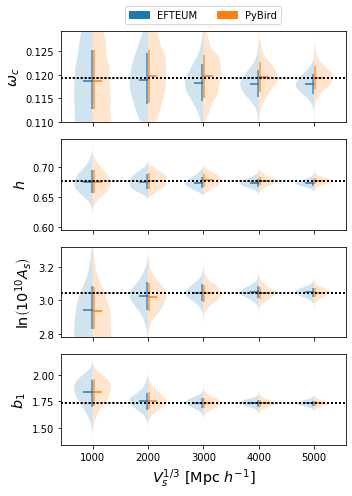

In [19]:
vols = [1000, 2000, 3000, 4000, 5000]
labels = [r"$\omega_c$", r"$h$", r"$\ln{\left(10^{10}A_s\right)}$", r"$b_1$"]

fig, ax = plt.subplots(4,1,sharex=True, figsize=(5,7))

for j, (axj, pi) in enumerate(zip(ax, ['omega_c', 'h', 'As', 'b1'])):
    
    for i in range(len(samples_list)):
        xs = np.linspace(mins[j], maxs[j], 300)
        emukde = samples_list[i].get1DDensity(pi)
        emupdf = emukde.Prob(xs)
        ISkde = IS_list[i].get1DDensity(pi)
        ISpdf = ISkde.Prob(xs)
        axj.fill_betweenx(xs, ISpdf/ISpdf.max()+i*3, x2=i*3, fc='tab:orange', alpha=0.2, zorder=0)
        axj.fill_betweenx(xs, -emupdf/emupdf.max()+i*3, x2=i*3, fc='tab:blue', alpha=0.2, zorder=0)
        ylim = axj.get_ylim()
        axj.set_ylim(max(priors[j,0], ylim[0]), min(priors[j,1], ylim[1]))
        axj.axhline(truths[j], linestyle=':', color='k')
        axj.vlines(i*3-0.05, marg_stats_emu_allV[i][j,0], marg_stats_emu_allV[i][j,2], color='tab:blue',
                   zorder=1, alpha=0.8)
        axj.vlines(i*3+0.05, marg_stats_pybird_allV[i][j,0], marg_stats_pybird_allV[i][j,2], color='tab:orange', zorder=1,
                   alpha=0.8)
        #axj.scatter(i*3, marg_res_fullchain_allV[i][j,1], marker='o', ec='tab:blue', fc='white', zorder=2)
        axj.hlines(marg_stats_emu_allV[i][j,1], i*3-0.5, i*3, color='tab:blue')
        #axj.scatter(i*3, marg_res_IS_allV[i][j,1], marker='x', color='tab:orange', zorder=2)
        axj.hlines(marg_stats_pybird_allV[i][j,1], i*3, i*3+0.5, color='tab:orange')
        axj.set_ylabel(labels[j], fontsize='x-large')


ax[-1].set_xlabel(r"$V_s^{1/3}\ [\mathrm{Mpc}\ h^{-1}]$", fontsize='x-large')
plt.xticks(ticks=np.arange(len(samples_list))*3, labels=vols)
legend_patches = [mpatches.Patch(label='EFTEUM', color='tab:blue'), mpatches.Patch(label='PyBird', color='tab:orange')]
# Great stack answer for putting legend outside plot
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot
ax[0].legend(handles=legend_patches, loc='lower center', bbox_to_anchor=(0,1.02,1,0.2), ncol=2)
plt.tight_layout()
plt.savefig(path_to_repo+f"plots/violins--z-0.38--w_pybird.png", dpi=300)